<a href="https://colab.research.google.com/gist/sumitra288/70e314cefb9dcf43589e65bdd64b0c3f/experiment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ucimlrepo scikit-learn matplotlib pandas numpy tabulate

In [2]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier as SklearnDT
import matplotlib.pyplot as plt
from tabulate import tabulate

np.random.seed(42)

def print_metrics(y_true, y_pred, title=None):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1)
    cm = confusion_matrix(y_true, y_pred)
    if title:
        print(f"=== {title} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print('\n')


def to_binary_labels(y_series):
    if y_series.dtype == object or y_series.dtype.name == 'category':
        values = sorted(y_series.unique())
        mapping = {values[0]: 0, values[-1]: 1} if len(values) == 2 else {v: i for i, v in enumerate(values)}
        return y_series.map(mapping).astype(int)
    else:
        return y_series.astype(int)


In [3]:
adult = fetch_ucirepo(id=2)
X = adult.data.features.copy()
y = adult.data.targets.copy()


if hasattr(y, 'iloc'):
    if isinstance(y, pd.DataFrame) and y.shape[1] == 1:
        y = y.iloc[:,0]


print('Features shape:', X.shape)
print('Targets shape:', y.shape)
print('\nSample rows:')
print(X.head())
print('\nTarget sample values:')
print(y.unique())

Features shape: (48842, 14)
Targets shape: (48842,)

Sample rows:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country  
0          2174             0              40  United

In [4]:
X = X.copy()
X = X.replace(' ?', np.nan)

data = pd.concat([X, y.rename('target')], axis=1)
print('Original rows:', data.shape[0])

data = data.dropna()
print('After dropna rows:', data.shape[0])

X = data.drop(columns=['target'])
y = data['target']

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

encoders = {}
for c in cat_cols:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c].astype(str))
    encoders[c] = le

y = to_binary_labels(y)

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print('Train:', X_train.shape, 'Val:', X_val.shape, 'Test:', X_test.shape)


Original rows: 48842
After dropna rows: 47621
Train: (28572, 14) Val: (9524, 14) Test: (9525, 14)


In [5]:
import numpy as np
import pandas as pd

class TreeNode:
    def __init__(self, depth=0):
        self.depth = depth
        self.is_leaf = False
        self.prediction = None
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None
        self.samples = 0
        self.value_counts = None


def gini(y):
    if len(y) == 0:
        return 0.0
    p = np.bincount(y, minlength=2) / len(y)
    return 1.0 - np.sum(p ** 2)


def entropy(y):
    if len(y) == 0:
        return 0.0
    p = np.bincount(y, minlength=2) / len(y)
    p = p[p > 0]
    return -np.sum(p * np.log2(p))


def weighted_impurity(left_y, right_y, impurity_func):
    n = len(left_y) + len(right_y)
    return (len(left_y) * impurity_func(left_y) + len(right_y) * impurity_func(right_y)) / n


class DecisionTreeFromScratch:
    def __init__(self, max_depth=None, min_samples_split=2, impurity='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.impurity = impurity
        self.root = None
        self.feature_importances_ = None

    def _impurity(self, y):
        return gini(y) if self.impurity == 'gini' else entropy(y)

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.n_features_ = X.shape[1]
        self.feature_importances_ = np.zeros(self.n_features_, dtype=float)
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        node = TreeNode(depth=depth)
        node.is_leaf = True
        node.samples = len(y)
        node.value_counts = pd.Series(y).value_counts().to_dict()
        node.prediction = pd.Series(y).mode()[0]
        return node

    def _best_split(self, X, y):
        best_feature, best_thresh, best_gain = None, None, -np.inf
        parent_impurity = self._impurity(y)
        n_samples, n_features = X.shape
        for feature in range(n_features):
            values = X[:, feature]
            unique_vals = np.unique(values)
            if unique_vals.shape[0] == 1:
                continue
            thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2.0
            for thresh in thresholds:
                left_mask = values <= thresh
                right_mask = ~left_mask
                if left_mask.sum() < self.min_samples_split or right_mask.sum() < self.min_samples_split:
                    continue
                left_y, right_y = y[left_mask], y[right_mask]
                imp = weighted_impurity(left_y, right_y, self._impurity)
                gain = parent_impurity - imp
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_thresh = thresh

        return best_feature, best_thresh, best_gain

    def get_feature_importances(self):
        if self.feature_importances_ is None or np.sum(self.feature_importances_) == 0:
            return np.zeros(self.n_features_)
        return self.feature_importances_ / self.feature_importances_.sum()

In [6]:
class DecisionTreeFromScratch:

    def _traverse_tree(self, x, node):
        """Traverses the tree to make a prediction for a single sample x."""
        if node.is_leaf:
            return node.prediction

        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

    def predict(self, X):
        """Makes predictions for a matrix of samples X."""
        X = np.asarray(X)

        return np.apply_along_axis(self._traverse_tree, axis=1, arr=X, node=self.root)

Tuning pre-pruned Decision Trees on validation set...

Validation Results (sorted):
 max_depth  min_samples_split  val_accuracy
       7.0                  2      0.581058
       7.0                  5      0.580953
       7.0                 10      0.580428
       5.0                  2      0.577173
       5.0                  5      0.577173
       5.0                 10      0.576963
       9.0                  5      0.574234
       9.0                  2      0.573814
       3.0                  5      0.573709
       3.0                  2      0.573709
       3.0                 10      0.573709
       9.0                 10      0.573289
      11.0                  5      0.570769
      11.0                 10      0.570349
      11.0                  2      0.570034
       NaN                 10      0.489710
       NaN                  5      0.477425
       NaN                  2      0.468501

Best Model Parameters:
max_depth=7, min_samples_split=2, val_acc=0.5811

=== Te

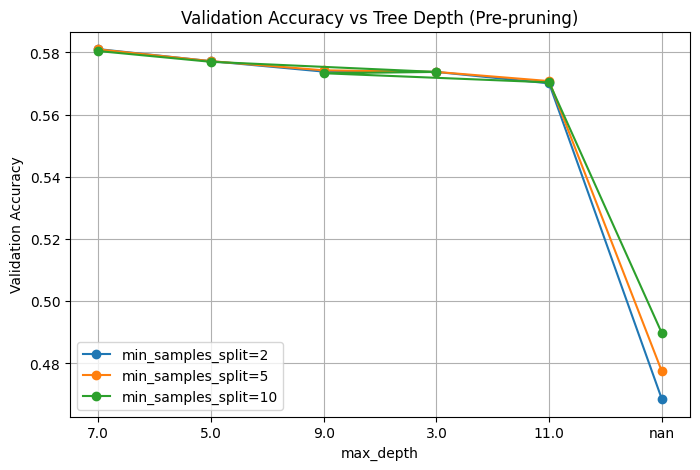

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

depth_options = [3, 5, 7, 9, 11, None]
min_samples_split_options = [2, 5, 10]

results = []

best_model = None
best_val_acc = 0
best_params = None

print("Tuning pre-pruned Decision Trees on validation set...\n")

for depth in depth_options:
    for min_samples in min_samples_split_options:
        model = DecisionTreeClassifier(
            criterion="gini",
            max_depth=depth,
            min_samples_split=min_samples,
            random_state=42
        )
        model.fit(X_train, y_train)

        y_val_pred = model.predict(X_val)
        val_acc = accuracy_score(y_val, y_val_pred)

        results.append({
            "max_depth": depth,
            "min_samples_split": min_samples,
            "val_accuracy": val_acc
        })

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model
            best_params = (depth, min_samples)

import pandas as pd
results_df = pd.DataFrame(results).sort_values(by="val_accuracy", ascending=False)
print("Validation Results (sorted):")
print(results_df.to_string(index=False))
print("\nBest Model Parameters:")
print(f"max_depth={best_params[0]}, min_samples_split={best_params[1]}, val_acc={best_val_acc:.4f}")

y_test_pred = best_model.predict(X_test)

test_acc = accuracy_score(y_test, y_test_pred)
unique_labels = np.unique(y_test)
if len(unique_labels) == 2:
    avg_type = "binary"
else:
    avg_type = "weighted"

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average=avg_type
)
cm = confusion_matrix(y_test, y_test_pred)

print("\n=== Test Set Evaluation ===")
print(f"Accuracy : {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(8, 5))
for min_samples in min_samples_split_options:
    subset = results_df[results_df["min_samples_split"] == min_samples]
    plt.plot(subset["max_depth"].astype(str), subset["val_accuracy"], marker="o", label=f"min_samples_split={min_samples}")

plt.title("Validation Accuracy vs Tree Depth (Pre-pruning)")
plt.xlabel("max_depth")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()
